# Mental Health Text Analysis
Let's start with downloading the DATA and doing some EDA.

In [ ]:
RANDOM_STATE = 42

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re
import kagglehub
#!pip install emoji==2.8.0
import emoji
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [ ]:
# Path to the dataset file
data_path = "/root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv"

# Load the dataset
df = pd.read_csv(data_path)

#Drop ID column, since it's superflous, just use panda's indexing
df_new = df.drop('Unnamed: 0', axis=1)

# Display the first few rows
print(df_new.head())

                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


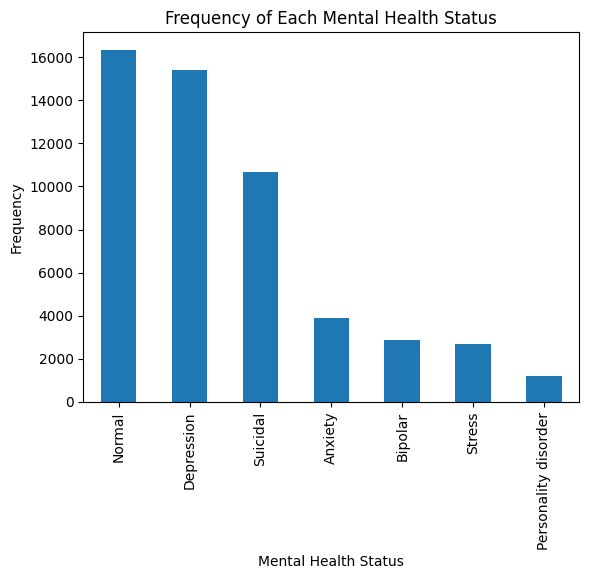

In [ ]:
#Bar chart to visualize the distribution of labels

df_new['status'].value_counts().plot(kind='bar')
plt.xlabel('Mental Health Status')
plt.ylabel('Frequency')
plt.title('Frequency of Each Mental Health Status')
plt.show()

Note that we have very imbalanced data, with certain classifications much less numerous than others. The "normal" classification, expectedly, is the most common one.

# Text Cleaning

In [ ]:
# Define a function to convert text to lowercase
def lowercase(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
    return text

# Apply this to your DataFrame column
df_new['cleaned_statement'] = df_new['statement'].apply(lowercase)

# View original and cleaned text side-by-side
print(df_new[['statement', 'cleaned_statement']].head(10))





                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   
5  every break, you must be nervous, like somethi...   
6  I feel scared, anxious, what can I do? And may...   
7    Have you ever felt nervous but didn't know why?   
8  I haven't slept well for 2 days, it's like I'm...   
9                 I'm really worried, I want to cry.   

                                   cleaned_statement  
0                                         oh my gosh  
1  trouble sleeping, confused mind, restless hear...  
2  all wrong, back off dear, forward doubt. stay ...  
3  i've shifted my focus to something else but i'...  
4  i'm restless and restless, it's been a month n...  
5  every break, you must be nervous, like somethi... 

In [ ]:
#Sanity check to make sure capital letters were removed

# Function to check for capital letters in a column
def check_capital_letters(column):
    return column.str.contains(r'[A-Z]').any()

# Check for capital letters in the "statement" column
contains_capitals = check_capital_letters(df_new['cleaned_statement'])

# Print the result of the sanity check
if not contains_capitals:
    print("Sanity check passed: No capital letters in the 'cleaned_statement' column.")
else:
    print("Sanity check failed: Capital letters found in the 'cleaned_statement' column.")



Sanity check passed: No capital letters in the 'cleaned_statement' column.


In [ ]:
# Check for NaNs and empty strings
empty_entries = df_new[df_new['cleaned_statement'].isna() | (df_new['cleaned_statement'] == "")]
print("Number of empty or NaN entries:", len(empty_entries))



Number of empty or NaN entries: 362


In [ ]:
# Remove rows where 'cleaned_statement' is either NaN or an empty string
df_new = df_new[df_new['cleaned_statement'].notna() & (df_new['cleaned_statement'] != "")]

#Sanity check--make sure NaN and empty values are removed

print("Any NaN values:", df_new['cleaned_statement'].isna().any())
print("Any empty strings:", (df_new['cleaned_statement'] == "").any())

Any NaN values: False
Any empty strings: False


Label Distribution After Cleaning:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


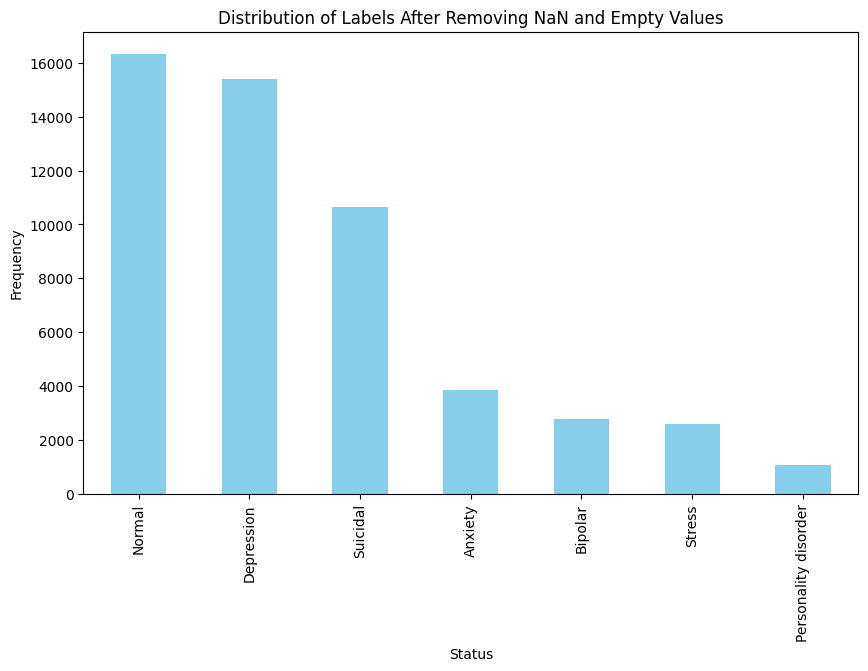

In [ ]:
#Check distribution of data after NaNs and empty values removed

label_distribution = df_new['status'].value_counts()
print("Label Distribution After Cleaning:")
print(label_distribution)


# Plot label distribution
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title('Distribution of Labels After Removing NaN and Empty Values')
plt.show()

Distribution looks relatively similar to original distribution after removing NaNs and empty values. This alleviates the concern that one column had a disproportionately high number of missing values.

In [ ]:
#Function to remove contractions and separate into two words

# Remove extra spaces around apostrophes in contractions
df_new['cleaned_statement'] = df_new['cleaned_statement'].str.replace(r"\s+([’'])\s+", r"\1", regex=True)

# Define a function to expand contractions
def expand_contractions(text):
    contractions_dict = {
        r"\bdon(?:'|’)?t\b": "do not",
        r"\bcan(?:'|’)?t\b": "cannot",
        r"\bi(?:'|’)?m\b": "i am",
        r"\byou(?:'|’)?re\b": "you are",
        r"\bthey(?:'|’)?ve\b": "they have",
        r"\bit(?:'|’)?s\b": "it is",
        r"\bis(?:'|’)?nt\b": "is not",
        r"\bwon(?:'|’)?t\b": "will not",
        r"\bdid(?:'|’)?nt\b": "did not",
        r"\bcould(?:'|’)?nt\b": "could not",
        r"\bwould(?:'|’)?nt\b": "would not",
        r"\bshould(?:'|’)?nt\b": "should not",
        r"\bdoes(?:'|’)?nt\b": "does not",
        r"\bain(?:'|’)?t\b": "is not",
        r"\bi(?:'|’)?ve\b": "i have",
        r"\bwe(?:'|’)?re\b": "we are",
        r"\bthere(?:'|’)?s\b": "there is",
        r"\bit(?:'|’)?d\b": "it would",
        r"\bwho(?:'|’)?s\b": "who is",
        r"\bwhat(?:'|’)?s\b": "what is",
        r"\bthat(?:'|’)?s\b": "that is",
        r"\blet(?:'|’)?s\b": "let us",
        r"\by(?:'|’)?all\b": "you all",
        r"\bma(?:'|’)?am\b": "madam"
    }

    # Apply each contraction replacement
    for contraction, expanded in contractions_dict.items():
        text = re.sub(contraction, expanded, text)
    return text

# Apply the contraction expansion function multiple times to catch overlaps
for _ in range(2):  # Repeat if necessary
    df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(expand_contractions)






In [ ]:
#Sanity check to make sure none of the specified contractions remain

# List of contraction patterns to check for remaining occurrences
remaining_contractions_patterns = [
    r"\bdon(?:'|’)?t\b", r"\bcan(?:'|’)?t\b", r"\bi(?:'|’)?m\b", r"\byou(?:'|’)?re\b",
    r"\bthey(?:'|’)?ve\b", r"\bit(?:'|’)?s\b", r"\bis(?:'|’)?nt\b", r"\bwon(?:'|’)?t\b",
    r"\bdid(?:'|’)?nt\b", r"\bcould(?:'|’)?nt\b", r"\bwould(?:'|’)?nt\b", r"\bshould(?:'|’)?nt\b",
    r"\bdoes(?:'|’)?nt\b", r"\bain(?:'|’)?t\b", r"\bi(?:'|’)?ve\b", r"\bwe(?:'|’)?re\b",
    r"\bthere(?:'|’)?s\b", r"\bit(?:'|’)?d\b", r"\bwho(?:'|’)?s\b", r"\bwhat(?:'|’)?s\b",
    r"\bthat(?:'|’)?s\b", r"\blet(?:'|’)?s\b", r"\by(?:'|’)?all\b", r"\bma(?:'|’)?am\b"
]

# Check for each contraction and count occurrences
for pattern in remaining_contractions_patterns:
    count = df_new['cleaned_statement'].str.contains(pattern, regex=True).sum()
    print(f"Contraction pattern '{pattern}': {count} occurrences remaining")


Contraction pattern '\bdon(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bcan(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bi(?:'|’)?m\b': 0 occurrences remaining
Contraction pattern '\byou(?:'|’)?re\b': 0 occurrences remaining
Contraction pattern '\bthey(?:'|’)?ve\b': 0 occurrences remaining
Contraction pattern '\bit(?:'|’)?s\b': 0 occurrences remaining
Contraction pattern '\bis(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bwon(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bdid(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bcould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bwould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bshould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bdoes(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bain(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bi(?:'|’)?ve\b': 0 occurrences remaining
Contraction pattern '\bwe(?:

In [ ]:
#Sanity check to check for presence of expanded form

# Dictionary of expected expansions
expected_expansions = {
    "do not": "do not",
    "cannot": "cannot",
    "i am": "i am",
    "you are": "you are",
    "they have": "they have",
    "it is": "it is",
    "is not": "is not",
    "will not": "will not",
    "did not": "did not",
    "could not": "could not",
    "would not": "would not",
    "should not": "should not",
    "does not": "does not",
    "is not": "is not",
    "i have": "i have",
    "we are": "we are",
    "there is": "there is",
    "it would": "it would",
    "who is": "who is",
    "what is": "what is",
    "that is": "that is",
    "let us": "let us",
    "you all": "you all",
    "madam": "madam"
}

# Check for presence of expanded forms
for expanded in expected_expansions.values():
    has_expansion = df_new['cleaned_statement'].str.contains(expanded, case=False).any()
    print(f"Expanded form '{expanded}' found? {has_expansion}")


Expanded form 'do not' found? True
Expanded form 'cannot' found? True
Expanded form 'i am' found? True
Expanded form 'you are' found? True
Expanded form 'they have' found? True
Expanded form 'it is' found? True
Expanded form 'is not' found? True
Expanded form 'will not' found? True
Expanded form 'did not' found? True
Expanded form 'could not' found? True
Expanded form 'would not' found? True
Expanded form 'should not' found? True
Expanded form 'does not' found? True
Expanded form 'i have' found? True
Expanded form 'we are' found? True
Expanded form 'there is' found? True
Expanded form 'it would' found? True
Expanded form 'who is' found? True
Expanded form 'what is' found? True
Expanded form 'that is' found? True
Expanded form 'let us' found? True
Expanded form 'you all' found? True
Expanded form 'madam' found? True


In [ ]:
# Removing duplicate statements
duplicate_statements = df_new[df_new['statement'].duplicated(keep=False)]['statement'].unique()

# Create a dictionary to store the results
duplicate_status_comparison = {}

# Iterate through duplicate statements
for statement in duplicate_statements:
  # Get all rows with the current duplicate statement
  rows_with_statement = df_new[df_new['statement'] == statement]

  # Check if 'status' values are different
  different_status = rows_with_statement['status'].nunique() > 1

  # Store the result in the dictionary
  duplicate_status_comparison[statement] = different_status
#Create mask to identify duplicate statements with different labels
mask = df_new['statement'].isin([statement for statement, has_different_status in duplicate_status_comparison.items() if has_different_status])

# Remove rows based on the mask
df_cleaned = df_new[~mask]

# Verify the changes
duplicate_statements_cleaned = df_cleaned[df_cleaned['statement'].duplicated(keep=False)]['statement'].unique()

duplicate_status_comparison_cleaned = {}

for statement in duplicate_statements_cleaned:
  rows_with_statement = df_cleaned[df_cleaned['statement'] == statement]
  different_status = rows_with_statement['status'].nunique() > 1
  duplicate_status_comparison_cleaned[statement] = different_status

false_count = sum(value == False for value in duplicate_status_comparison_cleaned.values())
true_count = sum(value == True for value in duplicate_status_comparison_cleaned.values())

print(f"Different Status: False Count: {false_count}")
print(f"Different Status: True Count: {true_count}")  #should be 0

Different Status: False Count: 1385
Different Status: True Count: 0


# Special Characters & Emojis

In [ ]:
def find_special_characters(text):
  """
  Finds and returns special characters in a string.

  Args:
    text: The input string.

  Returns:
    A list of special characters found in the string.
  """
  special_characters = re.findall(r"[^a-zA-Z0-9\s]", text)
  return special_characters

special_chars = (df_new['statement']).apply(find_special_characters)
all_special_chars = list(itertools.chain.from_iterable(special_chars))
unique_special_chars = list(set(all_special_chars))
print("Special characters:", unique_special_chars)

Special characters: ['💩', 'ô', 'ã', '‘', '#', '𝘅', '💜', '🙄', '🐰', '😥', '🥕', '\x98', '》', 'æ', '©', '🙃', '💸', 'Ä', '𝘀', ';', '>', '´', 'ï', '😅', '𝗽', '🧡', '●', '\u202c', '🤍', '\x95', '\U0001fae0', '😹', '𝗯', 'Đ', '‰', '🥱', '→', '💨', 'ấ', 'à', "'", '£', ']', '️', '𝗴', '×', '\x90', '❓', '🙂', '😵', '❌', '<', '💗', '🤫', '✨', '•', '✌', '@', 'Ë', 'µ', '𝗱', '\U0001fae4', 'ư', '⛽', '™', '🙏', ',', 'º', '😊', '💚', '⚠', '𝘂', '😖', '💋', 'ữ', '\x8d', '›', '👋', 'ú', '😦', '\x99', '?', '“', '💔', '¢', 'ó', 'ę', 'đ', '¬', '💅', '😒', '…', '¤', '—', '\x87', 'ủ', '`', 'ỳ', 'í', 'ž', '&', '\x83', '\U0001f979', 'Æ', '☠', '☹', '¦', '„', '\x92', '💕', '🤣', '🤩', '!', '😁', '°', '\x97', '¾', '🖕', '”', '😂', '♥', 'å', '\x9d', 'ë', '𝗼', '𝘁', '😣', '±', '😑', '➲', '🏻', '\ufeff', 'ể', 'Â', '\x9f', '%', '\u200d', '⛅', '🚩', '🙋', 'α', '¯', '\x94', '\\', '¶', 'Ê', '😨', '†', '𝗿', '\xad', '🤭', '–', ')', '😞', '𝗻', '😭', '\x89', '😪', '’', '[', '{', 'ツ', '\x8c', '¸', '»', '🎓', '÷', '😱', '.', '®', '🥰', '\U0001fae3', '🏴', '💫', 'ợ', '˜', '😠

In [ ]:
### Convert emoticons to unicode

def find_emoticons(text):
    """Finds a wide range of emoticons in a string and returns them."""
    # Define regular expressions for different types of emoticons
    western_pattern = r"[:;][-~]?[)D]"  # Western-style emoticons (e.g., :), :-D)
    eastern_pattern = r"[\(（][_oO.][\)）]"  # Eastern-style emoticons (e.g., (^_^))
    other_pattern = r"[\^_][.,:;'\"`´!@#\$%^&*\(\)\[\]\{\}\-=+\\\|\?\/<>~]" # More Complex emoticons

    # Find all matches using all patterns
    all_matches = re.findall(western_pattern, text) + \
                  re.findall(eastern_pattern, text) + \
                  re.findall(other_pattern, text)

    # Return the unique matches
    return list(set(all_matches))

In [ ]:
emoticon_representations = df_new['cleaned_statement'].apply(find_emoticons)
emoticons_representations = emoticon_representations[emoticon_representations.astype(bool)].tolist()
unique_emoticons_representations = list(set(item for sublist in emoticon_representations for item in sublist))


In [ ]:
emoticon_dict = {
    ":)": "smiling_face",
    ":-)": "smiling_face",
    ":-(": "frowning_face",
    ":(": "frowning_face",
    ";-)": "wink",
    ";)": "wink",
    ":D": "grinning_face",
    ":-D": "grinning_face",
    ":P": "face_with_stuck-out_tounge",
    ":'(": "crying_face",
    ":'-(": "crying_face",
    # Add more emoticons and their text descriptions as needed
}
def replace_emoticons_with_text(text):
    """Replaces emoticons in a string with their text descriptions."""
    for emoticon, text_rep in emoticon_dict.items():
        text = text.replace(emoticon, text_rep)
    return text

In [ ]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(replace_emoticons_with_text)


In [ ]:
def convert_emojis_to_unicode(text):
    """Converts emojis in a string to their Unicode representation."""
    return emoji.demojize(text)

In [ ]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(convert_emojis_to_unicode)
#this converts emojis to unicode representation.. such as :smiling_face_with_smiling_eyes:

In [ ]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs? going friday and need help hi i a...  


In [ ]:
def find_emoji_representations(text):
    """Finds emoji representations in a string and returns them."""
    # Define a regular expression pattern to match emoji representations
    pattern = r":[\w_]+:"  # Matches :xxx: format

    # Find all matches in the text
    emoji_matches = re.findall(pattern, text)

    # Return the emoji matches
    return emoji_matches

# Apply the function to the 'cleaned_statement' column
emoji_representations = df_new['cleaned_statement'].apply(find_emoji_representations)

# Filter out empty lists (statements without emoji representations)
emoji_representations = emoji_representations[emoji_representations.astype(bool)].tolist()

# Flatten the list of lists and get unique emoji representations
unique_emoji_representations = list(set(item for sublist in emoji_representations for item in sublist))

# Print some examples of emoji representations
print("Examples of emoji representations:")
for emoji_rep in unique_emoji_representations[:10]:  # Print up to 10 examples
    print(emoji_rep)

Examples of emoji representations:
:confused_face:
:loudly_crying_face:
:smiling_face_with_open_hands:
:sparkles:
:folded_hands:
:partying_face:
:28:
:sleepy_face:
:stop_sign:
:sparkling_heart:


In [ ]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs? going friday and need help hi i a...  


In [ ]:
special_chars = (df_new['cleaned_statement']).apply(find_special_characters)
all_special_chars = list(itertools.chain.from_iterable(special_chars))
unique_special_chars = list(set(all_special_chars))
print("Special characters:", unique_special_chars)

Special characters: ['𝗧', 'ô', 'ã', ':', '…', '¤', '—', '‘', '#', '(', '‡', '𝘅', '\x87', 'ª', '\x84', 'ủ', '€', '𝗹', '`', '↑', 'ỳ', '«', 'í', '+', 'ž', '\x98', '》', 'æ', '&', 'ƒ', '\x83', '𝘀', '¦', '„', '\x92', ';', '´', '>', '~', 'ä', '\x9c', 'ï', '\x80', '𝗰', 'œ', '𝗽', 'ê', '\u200e', '𝗘', '●', '|', '\u202c', '!', '$', '\x95', '¹', '\u200b', '¼', '°', '𝗯', '·', '¾', '\x97', '”', '‐', '𝗛', '‰', '𝗶', '/', '\x81', '\x91', '→', 'å', '¨', '\x9d', 'ë', '𝗼', '𝘁', 'ấ', '-', 'à', '±', '‚', 'ˆ', '➲', "'", '£', '\ufeff', 'ể', ']', '𝗴', '×', '§', '\x9f', '%', '*', 'ö', '\x90', '³', 'α', '¯', 'ả', '\x94', 'ı', '¶', '\\', '\u202d', 'ÿ', '¡', '\x8e', '<', 'ʻ', '\x8a', '_', '•', '½', '¥', '†', '𝗿', '\xad', '–', '@', ')', '𝟭', '𝗻', 'µ', 'â', 'ð', 'é', '"', '𝗱', '\x88', '\x89', 'ư', '’', '[', '\x8b', '^', '=', ',', '\x96', 'º', '{', 'ツ', '𝗠', '\x8c', '\x82', '¸', '»', '𝘂', 'ù', '𝗮', '²', 'ữ', '÷', '\x8d', '\x9a', '›', '¿', '\x8f', '.', '𝗲', 'ì', 'ú', '\x99', '?', '\u2060', '“', '¢', 'ợ', 'ó', 'á', '˜',

In [ ]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs? going friday and need help hi i a...  


In [ ]:
def remove_special_characters_except_emojis(text, emoji_representations):
    """Removes special characters except for those in emoji_representations."""

    # Create a regex pattern to match emoji representations
    emoji_pattern = "|".join(re.escape(emoji) for emoji in emoji_representations)

    # Create a regex pattern to match special characters excluding those in emoji representations
    special_chars_pattern = r"[^a-zA-Z0-9\s" + emoji_pattern + r"]"

    # Remove special characters using the pattern
    cleaned_text = re.sub(special_chars_pattern, "", text)

    return cleaned_text

In [ ]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(
    remove_special_characters_except_emojis, args=(unique_emoji_representations,)
)

In [ ]:
#final sanity check
special_chars = (df_new['cleaned_statement']).apply(find_special_characters)
all_special_chars = list(itertools.chain.from_iterable(special_chars))
unique_special_chars = list(set(all_special_chars))
print("Special characters:", unique_special_chars)
#colons are within emoji representations, as are underscores
#let's remove | next

Special characters: [':', '_', '|']


In [ ]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs going friday and need help hi i am...  


In [ ]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].str.replace("|", "")
df_new['cleaned_statement'] = df_new['cleaned_statement'].str.replace(":", "")
#this removes : from emoji representations and line escapes. we keep _ for emoji representations

In [ ]:
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)
#looking good. Can delete in final code

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs going friday and need help hi i am...  


In [ ]:
#Remove colons from unique_emoji_representations to make it easier for Michael to exclude these from lemmatization
unique_emoji_representations = [emoji.replace(":", "") for emoji in unique_emoji_representations]
unique_emoji_representations

['confused_face',
 'loudly_crying_face',
 'smiling_face_with_open_hands',
 'sparkles',
 'folded_hands',
 'partying_face',
 '28',
 'sleepy_face',
 'stop_sign',
 'sparkling_heart',
 'waving_hand_light_skin_tone',
 'tulip',
 'growing_heart',
 'heart_on_fire',
 'green_heart',
 'frowning_face_with_open_mouth',
 'melting_face',
 'heart',
 'confounded_face',
 'face_screaming_in_fear',
 'tired_face',
 'smiling_face_with_hearts',
 'face_with_diagonal_mouth',
 'high_voltage',
 'person_shrugging',
 'grinning_face',
 'slightly_smiling_face',
 'carrot',
 'face_with_hand_over_mouth',
 'crying_face',
 'face_holding_back_tears',
 'sad_but_relieved_face',
 'camera',
 'victory_hand',
 'fuel_pump',
 'heart_with_ribbon',
 'black_flag',
 'woman_facepalming',
 'angry_face',
 'triangular_flag',
 'exclamation_question_mark',
 'red_question_mark',
 'woman_facepalming_medium_skin_tone',
 'hourglass_not_done',
 'face_with_peeking_eye',
 'victory_hand_light_skin_tone',
 'relieved_face',
 'me',
 'down_arrow',
 'gr

# Stopword Removal

In [ ]:
#remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return " ".join(filtered_words)

df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Lemmatization
Process:
Run the lemmatization on nouns, verbs and adjectives. There are unavoidable words that may not be lemmatized due to the complexities of the English language such as homographs.

Ex. the word 'felt' can be the past tense of 'feel' or the fabric 'felt'. Because of this, the lemmatizer leaves the word as 'felt'

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Define function for lemmatization and do it for each part of speech
def lemmatize_text(text):
    if isinstance(text, str):
        # Split text into individual words
        words = text.split()
        lemmatized_words = []
        for word in words:
            # Check if the word is in unique_emoji_representation list and skip if true
            if word in unique_emoji_representations:
                lemmatized_words.append(word)
            else:
                # Apply lemmatization for nouns, verbs, and adjectives
                word = lemmatizer.lemmatize(word, pos="n")  # nouns
                word = lemmatizer.lemmatize(word, pos="v")  # verbs
                word = lemmatizer.lemmatize(word, pos="a")  # adjectives
                lemmatized_words.append(word)
        # Rejoin lemmatized words into a single string
        return " ".join(lemmatized_words)
    return text

In [ ]:
# Apply the lemmatization function
df_new['lemmatized_statement'] = df_new['cleaned_statement'].apply(lemmatize_text)

# Compare cleaned and lemmatized statements
comparison = df_new[['cleaned_statement', 'lemmatized_statement']].head(10)
print(comparison)

                                   cleaned_statement  \
0                                            oh gosh   
1  trouble sleeping confused mind restless heart ...   
2  wrong back dear forward doubt stay restless re...   
3         shifted focus something else still worried   
4                   restless restless month boy mean   
5  every break must nervous like something wrong ...   
6  feel scared anxious may family us protected sm...   
7                       ever felt nervous didnt know   
8  havent slept well 2 days like restless huh fro...   
9                            really worried want cry   

                                lemmatized_statement  
0                                            oh gosh  
1     trouble sleep confuse mind restless heart tune  
2  wrong back dear forward doubt stay restless re...  
3             shift focus something else still worry  
4                   restless restless month boy mean  
5  every break must nervous like something wrong ... 

In [ ]:
#counting rows with blank statements - removing stopwords created blank statements. only 140 rows so we decided to just remove them
blank_statements = df_new[df_new['lemmatized_statement'] == '']
print(blank_statements)

#removing rows with blank statements
df_new = df_new[df_new['lemmatized_statement'] != '']

#counting rows again
blank_statements = df_new[df_new['lemmatized_statement'] == '']
print(blank_statements)

                   statement      status cleaned_statement  \
1224           Just on again      Normal                     
1868          where are you?      Normal                     
2350           Where is this      Normal                     
2602          where are you?      Normal                     
2633            Can you not?      Normal                     
...                      ...         ...               ...   
33802    how can he do that?      Normal                     
33856   what were you doing?      Normal                     
33879                    so?      Normal                     
33892  why did they do that?      Normal                     
39840             this is it  Depression                     

      lemmatized_statement  
1224                        
1868                        
2350                        
2602                        
2633                        
...                    ...  
33802                       
33856                  

# Train/Test/Split & Final EDA

Now that the text preprocessing is done, we'll split the dataset into training, validation, and do some more EDA.

In [ ]:
#Split data into training, validation, and test sets, converting to arrays

# Convert the DataFrame to a NumPy array
mh_array = df_new.to_numpy()

# Grab text and labels only
X = mh_array[:, 3] #lemmatized text
y = mh_array[:, 1] #labels

# Encode labels as integers for Tensorflow
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train, val and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4,random_state = RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,random_state = RANDOM_STATE)

In [ ]:
# Check lengths of each dataset
print(f"Length of Training set (X_train, y_train): {len(X_train)} samples, {len(y_train)} labels")
print(f"Length of Validation set (X_val, y_val): {len(X_val)} samples, {len(y_val)} labels")
print(f"Length of Test set (X_test, y_test): {len(X_test)} samples, {len(y_test)} labels")

Length of Training set (X_train, y_train): 31524 samples, 31524 labels
Length of Validation set (X_val, y_val): 10508 samples, 10508 labels
Length of Test set (X_test, y_test): 10509 samples, 10509 labels


In [ ]:
#View encoding for each label
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

print("Label encoding mapping:")
for label, number in label_mapping.items():
    print(f"'{label}' -> {number}")

Label encoding mapping:
'Anxiety' -> 0
'Bipolar' -> 1
'Depression' -> 2
'Normal' -> 3
'Personality disorder' -> 4
'Stress' -> 5
'Suicidal' -> 6


In [ ]:
#Check text lengths only in training dataset (so as to not learn anything about validation and test datasets at this point)

# Ensure all entries in X_train are strings
X_train = [str(text) if not isinstance(text, str) else text for text in X_train]

# Check lengths of text in the training dataset
text_lengths = [len(text) for text in X_train]

# Display basic statistics about text lengths
print(f"Number of training samples: {len(text_lengths)}")
print(f"Minimum text length: {min(text_lengths)} characters")
print(f"Maximum text length: {max(text_lengths)} characters")
print(f"Average text length: {sum(text_lengths) / len(text_lengths):.2f} characters")

# Optionally, display the first 5 text lengths for verification
print("\nFirst 5 text lengths:")
print(text_lengths[:5])

Number of training samples: 31524
Minimum text length: 2 characters
Maximum text length: 25289 characters
Average text length: 323.98 characters

First 5 text lengths:
[61, 93, 285, 28, 790]


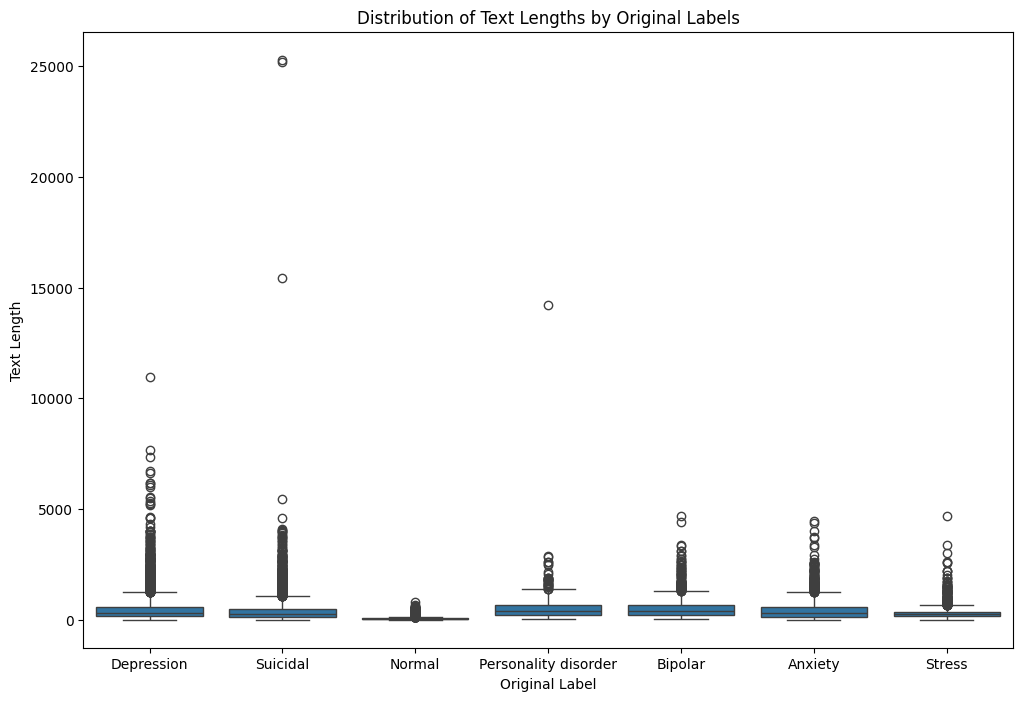

In [ ]:
#Visual depiction of distribution of text lengths in X_train

# Decode the encoded labels to their original form
original_labels = label_encoder.inverse_transform(y_train)

# Combine X_train, original labels, and text lengths into a DataFrame
train_df = pd.DataFrame({
    'text': X_train,
    'label': original_labels,  # Use original (non-encoded) labels
    'text_length': text_lengths
})

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title('Distribution of Text Lengths by Original Labels')
plt.xlabel('Original Label')
plt.ylabel('Text Length')
plt.show()


As we can see, text entries labeled "normal" are much shorter than other entries. Also, it is interesting to see the outliers of each label. Shows that a lot of statements are short in nature, but we have a significant amount for each label in Quartile 4 that have a very high text length.

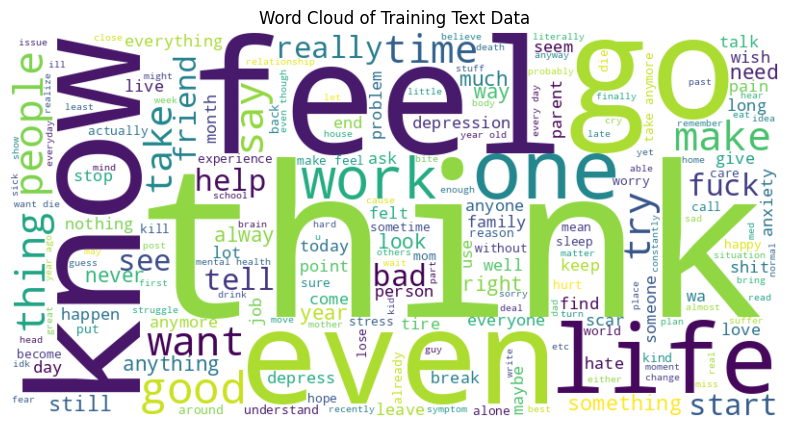

In [ ]:
#Word Cloud to show commonly occuring words in X_train only

from wordcloud import WordCloud, STOPWORDS

# Combine all text data from X_train
text_data = ' '.join(str(text) for text in X_train)  # Handle X_train as a list

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Training Text Data')
plt.show()

Saving the datasets into csvs for to vectorize and build models on in the next file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

pd.DataFrame(X_train).to_csv('/content/drive/MyDrive/207/X_train.csv', index=False)
pd.DataFrame(y_train).to_csv('/content/drive/MyDrive/207/y_train.csv', index=False)
pd.DataFrame(X_val).to_csv('/content/drive/MyDrive/207/X_val.csv', index=False)
pd.DataFrame(y_val).to_csv('/content/drive/MyDrive/207/y_val.csv', index=False)
pd.DataFrame(X_test).to_csv('/content/drive/MyDrive/207/X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('/content/drive/MyDrive/207/y_test.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
